In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt


## Creation of artificial data

Data are created artificially with a mixed Gaussian distribution of two clusters, with specific means and standard deviations

In [ ]:

def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [16, 16], stds1 = [3, 3], stds2 = [2, 1]):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2    """
    means = torch.zeros(2)
    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]
    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    # plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1])
    # plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker = 'x')
    # plt.show()
    #Create samples with bias
    samplesAllBias = torch.cat((samplesClass1Bias, samplesClass2Bias), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = 0 * torch.ones(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAllBias, samplesClass1, samplesClass2)


'''
Creates data with gaussian distribution
'''
def createDataOneClass(means, covarianceMatrix, numberSamples):
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    # Takes the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    
    return samples

In [ ]:
def splitData(TargetsAll, SamplesAll):
  c=torch.randperm(400)

  samp=SamplesAll[c]
  targ=TargetsAll[c]

  partitions_samp_train, partitions_samp_test = samp[:280], samp[280:]
  partitions_targ_train, partitions_targ_test = targ[:280], targ[280:]

  return partitions_samp_train, partitions_samp_test, partitions_targ_train, partitions_targ_test

## Train model
Train the model using the least squares approach

In [ ]:
  
  def estimateOptimumW(TargetsAll, SamplesAll, P = 20, coefAprendizaje = 1):
    """ 
    Train model
    Estimate the optimum W with NO FORS, only for epochs
    param TargetsAll, NumSamples x 1 matrix with target values (1 or -1)
    param SamplesAll, NumSamples x NumDimensions 
    return wOpt, array with optimum weights
    """
    #implementar el criterio del perceptron, hacer aleatorio    
    wOpt = torch.ones(3, 1) 
    
    #lista de errores
    errorPerEpoch = []    
    for epoch in range(0, P):
        y_mw = 1/(1+np.exp(-SamplesAll.mm(wOpt)))
        #no reescribir la matriz de observaciones
        SamplesAllIter = SamplesAll.clone()
        
        
        #Calcular el vector gradiente
        #crear un ciclo que se va a repetir por P veces, cantidad de epochs
        error_grad_all_observations = SamplesAllIter * (TargetsAll - y_mw)  
        
        error_grad_sum = torch.sum(error_grad_all_observations, 0)       
        #make it a column matrix 
        error_grad_sum = error_grad_sum.unsqueeze(0).transpose(0, 1)       
        #Actualizar el vector de pesos        
        wOpt = wOpt + coefAprendizaje * error_grad_sum           
        
        
        #Imprimir el error total
        EstimatedTargets = forward(SamplesAll, wOpt) #************       
        error = evaluateError(TargetsAll, EstimatedTargets)  
        #print("Epoch: ", epoch, " error: ", error)
        errorPerEpoch += [error]
    return wOpt, errorPerEpoch


  def forward(SamplesAll, wOpt):
    """
    Get model output, with NO FORS
    param TargetsAll
    return EstiwOpt,matedTargets, with 0 or 1
    """
    EstimatedTargetsAll = SamplesAll.mm(wOpt)
    EstimatedTargetsAll[EstimatedTargetsAll >= 0.5] = 1
    EstimatedTargetsAll[EstimatedTargetsAll < 0.5] = 0
    return EstimatedTargetsAll   
    
   
  
  def evaluateError(TargetsAll, EstimatedTargetsAll):
    """
    Evaluate model error using the euclidian distance
    param TargetsAll, real targets
    param EstimatedTargets
    """
    error = torch.norm(TargetsAll - EstimatedTargetsAll, 1) / TargetsAll.shape[0]
    return error

## Main function and error graphing by epoch

The main function creates the dataset and trains the perceptron, to finally plot the error by epoch.

In [ ]:
def algorithm(partitions_targ, partitions_samp, epoch):
  wOpt, errorPerEpoch = estimateOptimumW(partitions_targ, partitions_samp, P = epoch, coefAprendizaje = 0.001)    
  EstimatedTargetsAll = forward(partitions_samp, wOpt)
  print("Final error with training data")
  error = evaluateError(partitions_targ, EstimatedTargetsAll)        
  print(error)
  plt.plot(errorPerEpoch)
  plt.ylabel("Number of misclassified observations")
  plt.xlabel("Epoch")
  plt.show()
  return wOpt, errorPerEpoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


Final error with training data
tensor(0.)


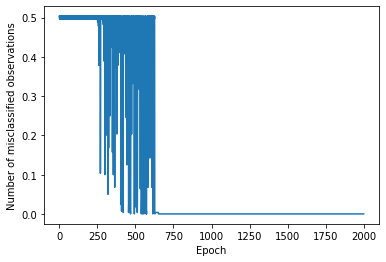

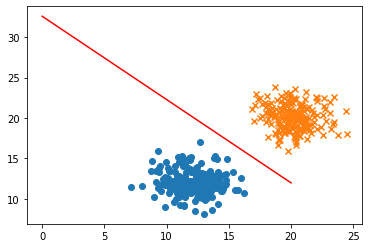

Final error with test data for 2000 epochs is --> 0.0


In [ ]:
"""
Main function separable data
"""
def main():
    (TargetsAll, SamplesAll, samplesClass1, samplesClass2) = createData(numberSamplesPerClass = 200, mean1 = [12,12], mean2 = [20, 20], stds1 = [2.5, 2.5], stds2 = [2, 2])    
    partitions_samp_train, partitions_samp_test, partitions_targ_train, partitions_targ_test = splitData(TargetsAll, SamplesAll)
    #Train  
    epochs = 2000
    trained_model, errorPerEpoch = algorithm(partitions_targ_train, partitions_samp_train, epochs)
    #print(partitions_samp_train)
    #print(trained_model)
    x = np.linspace(0,20)
    y = (-trained_model[1]*x - trained_model[0]) / trained_model[2]

    
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1])
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker = 'x')
    plt.plot(x,y, color='r')
    plt.show()
    
    #Test
    EstimatedTargets = forward(partitions_samp_test, trained_model)
    error = evaluateError(partitions_targ_test, EstimatedTargets)
    print("Final error with test data for {} epochs is --> {}".format(epochs, error))
main()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


Final error with training data
tensor(0.4786)


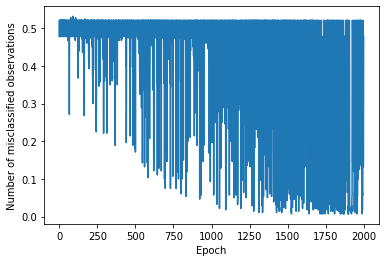

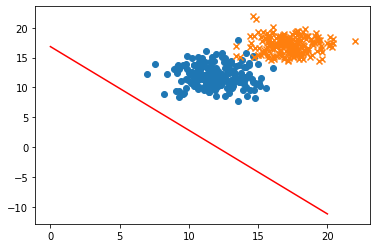

Final error with test data for 2000 epochs is --> 0.550000011920929


In [ ]:
"""
Main function not separable data
"""
def main():
    (TargetsAll, SamplesAll, samplesClass1, samplesClass2) = createData(numberSamplesPerClass = 200, mean1 = [12,12], mean2 = [17, 17], stds1 = [3, 3], stds2 = [2, 2])    
    partitions_samp_train, partitions_samp_test, partitions_targ_train, partitions_targ_test = splitData(TargetsAll, SamplesAll)
    #Train  
    epochs = 2000
    trained_model, errorPerEpoch = algorithm(partitions_targ_train, partitions_samp_train, epochs)
    
    x = np.linspace(0,20)
    y = (-trained_model[1]*x - trained_model[0]) / trained_model[2]

    
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1])
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker = 'x')
    plt.plot(x,y, color='r')
    plt.show()

    #Test
    EstimatedTargets = forward(partitions_samp_test, trained_model)
    error = evaluateError(partitions_targ_test, EstimatedTargets)
    print("Final error with test data for {} epochs is --> {}".format(epochs, error))
main()